# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [ ]:
USER_NAME = u"Зайдель".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

$$L(w) = \frac{1}{N}\sum_i \log(1 + e^{-y^{(i)} <w,x^{(i)}>}) + \frac{1}{C}\sum_{j=1}^{m} w_j^2 \rightarrow \min_w$$

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.
$$L(w) = \frac{-1}{N}\sum_i \log( \sigma(y^{(i)} <w,x^{(i)}>)) + \frac{1}{C}\sum_{j=1}^{m} w_j^2 \rightarrow \min_w$$
$$ \frac{\partial L}{\partial w_k} =  -\frac{1}{N} \sum_i  y^{(i)} x^{(i)}_k \sigma(-y^{(i)} <w,x^{(i)}>)   + \frac{2}{C}  w_k$$

$$ w_{n+1} = w_{n} - \eta_{n} \frac{\partial L}{\partial w} (w_n) $$

$$ w_{n+1} = w_{n} + \eta_{n} \frac{1}{N} \sum_i  y^{(i)} x^{(i)} \sigma(-y^{(i)} <w_{n},x^{(i)}>)   - \eta_{n}     \frac{2}{C} w $$

$$\eta_n = \frac{alpha}{n}$$

## Имплементация (5 баллов)

In [453]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, verbose = False, minibatch_size = 10, seed = None):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.verbose = verbose
        self.minibatch_size = minibatch_size
        self.seed = seed
        
    def test(self):
        print self.__sigm(np.array([0,0]))
        
        X = np.array([ [2,1], [1,2] ])
        y = np.array([1, -1])
        self.minibatch_size = 2;
        
        print "X:", X
        print "y:", y
        

        
        self.fit(X, y)
        
        
        
        return
        
    
    def fit(self, X_train, y_train=None):
        '''
        Обучение модели
        '''
        np.random.seed(self.seed)
        
        y = np.copy(y_train)
        X = np.copy(X_train)
        
        X = np.c_[X_train, np.ones(X.shape[0])]
        
        y[y == 0] = -1
        
        

        X_dim = X.shape[1]
        X_size = X.shape[0]
        
        
        #print y
        
        model = np.random.uniform(low= -2.0/(X_dim), high=2.0/(X_dim), size=(X_dim,))
       # model = np.ones(X_dim)
       # print "start_model:", model
        
        eta = 1.0
        
        self.errors = []
        
        for epoch in xrange(1,self.max_epoch):
            eta = self.alpha/epoch
            np.random.shuffle(X)
            np.random.shuffle(y)

            for b_ind in range(0, X_size, self.minibatch_size):
                X_batch = X[b_ind: b_ind + self.minibatch_size]
                y_batch = y[b_ind: b_ind + self.minibatch_size]

                batch_size = X_batch.shape[0]
                
                
                #print "sigmoid:", self.__sigm( - y_batch * X_batch.dot( model ) )
                #print "to_sum: ", y_batch[:, np.newaxis] * self.__sigm( - y_batch * X_batch.dot( model ) )[:, np.newaxis] * X_batch
                
                buffer_array = np.sum( y_batch[:, np.newaxis] * 
                                      self.__sigm( - y_batch * X_batch.dot( model ) )[:, np.newaxis] * X_batch, 
                                      axis = 0)
                
               # print "buffer_array: ", buffer_array 
                
               # print "coef_model: ", (1 - 2.0 * eta/self.C )
               # print "add_2:", eta * ( 1.0/ batch_size) * buffer_array 
                #print buffer_array
                model = (1 - 2.0 * eta/self.C ) * model +  (eta/batch_size) * buffer_array 
                
            error = (-1.0/ X_size) * np.sum( np.log( self.__sigm(y * X.dot(model)) ) , axis = 0)  + 1.0/self.C * np.sum(model**2)
            self.errors.append(error)
            
            if self.verbose == True: 
                print "epoch: {0} , eta: {1} , error: {2}".format(epoch, eta, error)
                print "  model: {0}".format(model)
               # print "  X.dot(model): {0}".format(X.dot(model))
                
                
        self.model = model
        
        return self
    
    def __sigm(self, z):
        return 1.0/(1.0 + np.exp(-z))
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
       # print np.c_[X, np.ones(X.shape[0])]
        fff = np.c_[X, np.ones(X.shape[0])]
        y_hat = np.sign(fff.dot(self.model))
        
        
        y_hat[y_hat == -1] = 0
        
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        return self.__sigm(np.c_[X, np.ones(X.shape[0])].dot(self.model))

In [345]:
X = np.array([[1,1] , [2,2]])
y = np.array([1, -1])
model = MySGDClassifier(verbose = True)
model.test()

[ 0.5  0.5]
X: [[2 1]
 [1 2]]
y: [ 1 -1]
epoch: 1 , eta: 0.01 , error: 1.43063624719
  model: [-0.24727271  0.27759744 -0.64493708]
epoch: 2 , eta: 0.005 , error: 1.41364747757
  model: [-0.24232604  0.27449643 -0.63777141]
epoch: 3 , eta: 0.00333333333333 , error: 1.4025580219
  model: [-0.23907338  0.2724401  -0.63304933]
epoch: 4 , eta: 0.0025 , error: 1.14129958225
  model: [-0.23790615  0.27215337 -0.62953497]
epoch: 5 , eta: 0.002 , error: 1.1369479482
  model: [-0.23698038  0.27192196 -0.62673972]
epoch: 6 , eta: 0.00166666666667 , error: 1.38601526338
  model: [-0.23538087  0.27089446 -0.62442109]
epoch: 7 , eta: 0.00142857142857 , error: 1.12982398591
  model: [-0.2347304   0.27072964 -0.62244133]
epoch: 8 , eta: 0.00125 , error: 1.12716966905
  model: [-0.23416404  0.27058472 -0.62071475]
epoch: 9 , eta: 0.00111111111111 , error: 1.12482391866
  model: [-0.23366279  0.27045536 -0.61918444]


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

400


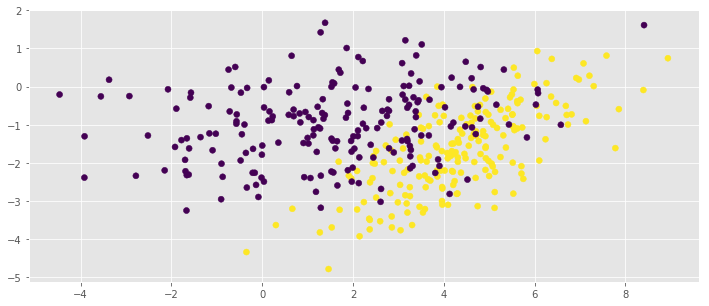

In [613]:
np.random.seed(123)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

print X.shape[0]

plt.scatter(X[:,0], X[:,1], c=y)

0.7625
0.7625
[ 0.00566917 -0.01546077 -0.04667791]


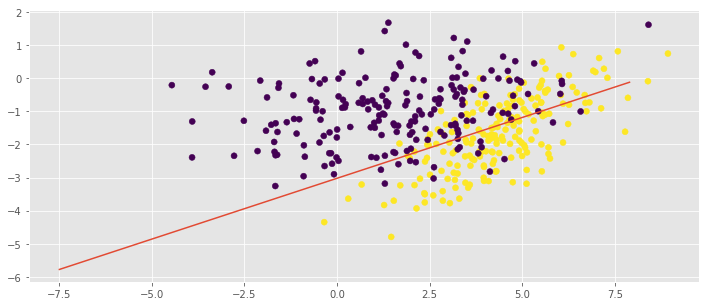

In [644]:
model = MySGDClassifier(max_epoch=1000, C = 5 , alpha= 0.01, minibatch_size=50, seed =123)
model.fit(X, y)

y_pred = model.predict(X)
plt.scatter(X[:,0], X[:,1], c=y)

x_plt = np.arange(-7.5,8.0, 0.1)
w = model.model
y_plt = (-w[2]-w[0]*x_plt)/w[1]
plt.plot(x_plt,y_plt)

print roc_auc_score(y, y_pred)
print accuracy_score(y, y_pred)
print w
# print y_pred
# print y

In [466]:
# Cs = np.linspace(start=0.1, stop=10, num = 10)
# alphas = np.linspace(start=0.0001, stop=1.0, num = 10)
# results = np.zeros((Cs.shape[0], alphas.shape[0]))

# for i in range(Cs.shape[0]):
#     for j in range(alphas.shape[0]):
#         model = MySGDClassifier(max_epoch=1000, C = Cs[i], alpha=alphas[i], minibatch_size=50, seed = 123)
#         model.fit(X, y)

#         y_pred = model.predict(X)
#         results[i,j] = roc_auc_score(y, y_pred)

# print results
# print np.argmax(results)

0.625
0.625
[ 0.00566917 -0.01546077 -0.04667791 -0.01442302]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.
  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  

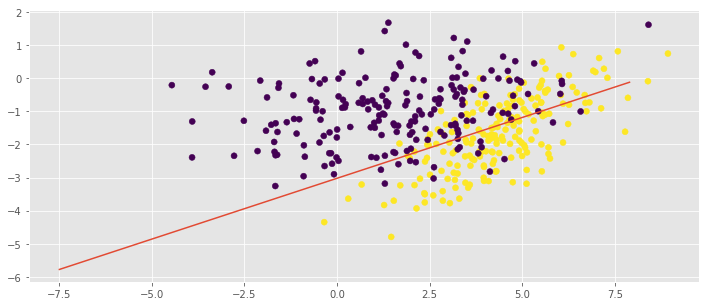

In [649]:
from sklearn.linear_model import SGDClassifier

sk_model = SGDClassifier(loss = 'log', penalty='l2', alpha= 1/5, max_iter=1000, tol = None, 
                      learning_rate='invscaling', eta0 = 0.01 , power_t = 1.0)
sk_model.fit(X, y)
sk_y_pred = sk_model.predict(X)

plt.scatter(X[:,0], X[:,1], c=y)

x_plt = np.arange(-7.5,8.0, 0.1)

sk_w = sk_model.coef_[0]
sk_w = np.append(w,sk_model.intercept_)
sk_y_plt = (-sk_w[2] - sk_w[0]*x_plt)/sk_w[1]

plt.plot(x_plt,sk_y_plt)

print accuracy_score(y, sk_y_pred)
print roc_auc_score(y, sk_y_pred)
print sk_w

print sk_y_pred

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [138]:
from sklearn.datasets import make_classification

In [139]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

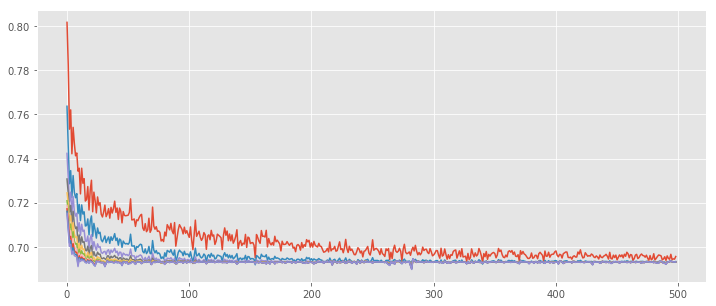

In [659]:
## Your Code Here
alphas = np.linspace(start=0.01, stop=0.1, num = 10)
results = []
for a in alphas:
    model = MySGDClassifier(max_epoch=500, C = 5 , alpha= a, minibatch_size=50, seed =123)
    model.fit(X, y)
    results.append(model.errors)


for y_plt in results:
    x_plt = np.arange(len(y_plt))
    plt.plot(x_plt,y_plt)


## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

[  1.00000000e+03   2.15443469e+02   4.64158883e+01   1.00000000e+01
   2.15443469e+00   4.64158883e-01   1.00000000e-01   2.15443469e-02
   4.64158883e-03   1.00000000e-03]


/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in exp
/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in log


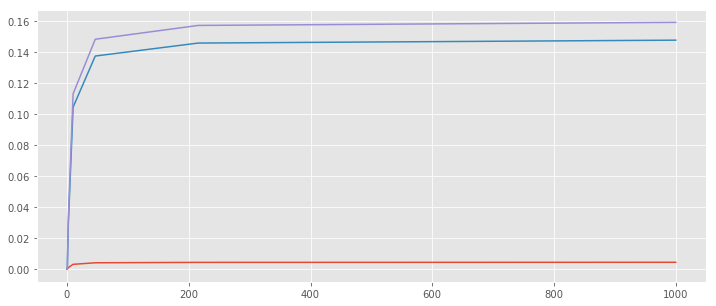

In [595]:
## Your Code Here
Cs = np.logspace(3, -3, 10)
print Cs
weights = np.empty(shape = (Cs.shape[0], X.shape[1]+1))

for idx, c in enumerate(Cs):
    model = MySGDClassifier(max_epoch=500, C = c, alpha=0.01, minibatch_size=100, seed = 0)
    model.fit(X, y)

    y_pred = model.predict(X)
    weights[idx] = np.array(model.model)

plt_x = Cs
plt_y = weights.transpose()

for i in range(plt_y.shape[0]):
    plt.plot(plt_x,plt_y[i])

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [ ]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [ ]:
df_data.shape

In [ ]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [ ]:
df_data.head().T

In [ ]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [ ]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [ ]:
## Youd Code Here

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [ ]:
## Youd Code Here